In [1]:
%cd ..

/home/alex404/code/retinal-rl


In [2]:
import numpy as np
from scipy import stats
from scipy.ndimage import gaussian_filter1d

import matplotlib as mpl


import matplotlib.style as mplstyle

#mplstyle.use("fast")

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=50,
)

In [4]:
sim_recs = np.load(
    "/home/alex404/code/retinal-rl/train_dir/reduxicle3/analyses/testing/data/sim_recs.npy",
    allow_pickle=True,
).tolist()

In [5]:
def process_attributions(attrs):
    t_smooth_sigma = 0.5
    vlim_factor = 1.2

    attrs = gaussian_filter1d(
        attrs, t_smooth_sigma, 3
    )
    # attrs = attrs0.astype(float)
    vlim = np.max(np.abs(attrs)) * vlim_factor

    pclps = np.mean(np.clip(attrs, 0, vlim), 2)
    nclps = np.mean(np.clip(-attrs, 0, vlim), 2)
    # Take each image in attrs, and put positive values in the red channel, negative in the blue channel
    attrs = np.stack(
        [pclps, np.zeros_like(pclps), nclps],
        axis=2,
    )

    return attrs, vlim

In [6]:
def simulation_plot(
    sim_recs,
    frame_step=100,
    animate=False,
    fps=35,
    prgrs=True,
):
    imgs = sim_recs["imgs"]
    # nimgs0 = sim_recs["nimgs"]
    attrs = sim_recs["attrs"]
    hlths0 = sim_recs["hlths"]
    crwds0 = sim_recs["crwds"]
    dns = sim_recs["dns"]
    dndices = np.where(dns)

    attrs, vlim = process_attributions(attrs)
    # imgs = normalize_data(imgs0)
    # gimgs0 = np.average(imgs,axis=2,weights=greyscale)

    # attrs = np.abs(attrs)
    # gimgs = np.array([gimgs0,gimgs0,gimgs0]).transpose(1,2,0,3)
    # nimgs = normalize_data(nimgs0)
    # attrs1 = normalize_data(attrs0)
    # attrs = gimgs + attrs1

    crwds = np.ma.array(crwds0, mask=dns)
    hlths = np.ma.array(hlths0, mask=dns)

    if not animate:
        img0 = imgs[:, :, :, frame_step]
        # nimg0 = nimgs[:, :, :, frame_step]
        attr0 = attrs[:, :, :, frame_step]
    else:
        img0 = imgs[:, :, :, 0]
        # nimg0 = nimgs[:, :, :, 0]
        attr0 = attrs[:, :, :, 0]

    t_max = imgs.shape[3]

    mosaic = """
        aaabb
        aaabb
        cccdd
        cccdd
        """

    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(6, 3),
    )

    imax = ax_dict["a"]
    rwdax = ax_dict["b"]
    hlthax = ax_dict["d"]
    # nimax = ax_dict["e"]
    attax = ax_dict["c"]

    trng = np.linspace(0, t_max - 1, t_max)

    # FoV
    imax.set_title("Field of View")
    imax.set_xticks([])
    imax.set_yticks([])
    im = imax.imshow(img0, interpolation=None)
    imax.spines["top"].set_visible(True)
    imax.spines["right"].set_visible(True)

    # Attribution
    attax.set_title("Attribution")
    attax.set_xticks([])
    attax.set_yticks([])
    attax.spines["top"].set_visible(True)
    attax.spines["right"].set_visible(True)

    att_img = attax.imshow(img0)
    att = attax.imshow(
        attr0,
        interpolation=None,
        alpha=0.5,
        cmap="seismic",
        vmin=-vlim,
        vmax=vlim,
    )

    # Rewards
    r_max = np.max(crwds)

    rwdax.set_title("Cumulative Reward")
    rwdax.set_xlim([0, t_max])
    rwdax.set_ylim([0, r_max])

    rwdax.plot(trng, crwds, "k-")
    rwdax.vlines(
        dndices,
        0,
        r_max,
        linestyle="dashed",
        linewidth=1,
        color="blue",
    )
    (rline,) = rwdax.plot(
        trng[0], crwds[0], "g-", linewidth=1
    )

    # Health dynamics
    hlthax.set_title("Health")
    hlthax.set_xlim([0, t_max])
    hlthax.set_ylim([0, 100])

    hlthax.plot(trng, hlths, "k-")
    hlthax.vlines(
        dndices,
        0,
        100,
        linestyle="dashed",
        linewidth=1,
        color="blue",
    )

    (hline,) = hlthax.plot(
        trng[0], hlths[0], "r-", linewidth=1
    )

    if not animate:
        return fig

    else:

        def update(i):
            img = imgs[:, :, :, i]
            im.set_array(img)

            # nimg = nimgs[:, :, :, i]
            # nim.set_array(nimg)

            attr = attrs[:, :, :, i]
            att.set_array(attr)

            att.set_array(
                attr
            )  # -np.median(np.mean(attr, 2)))
            att_img.set_array(img)

            rline.set_data(trng[0:i], crwds[0:i])
            hline.set_data(trng[0:i], hlths[0:i])

        anim = FuncAnimation(
            fig,
            update,
            frames=tqdm(
                range(1, t_max),
                disable=not (prgrs),
                desc="Animating Simulation",
            ),
            interval=1000 / fps,
        )

        return anim

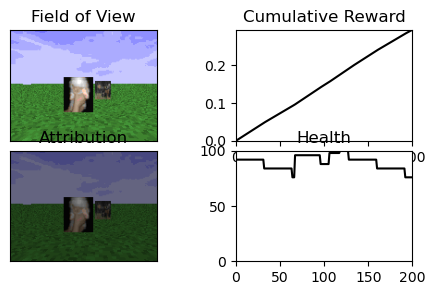

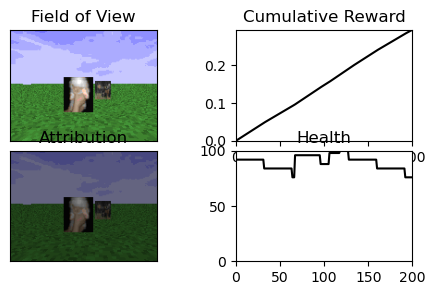

In [7]:
simulation_plot(
    sim_recs,
    frame_step=100,
    animate=False,
    fps=35,
    prgrs=True,
)

In [8]:
plt.show()